# PCA Implementation from Scratch for 8 bit image comrpession

In [ ]:
# import the necessary packages
import numpy as np # for numerical operations
from matplotlib import pyplot as plt  # for visualization
import cv2 # for image processing
from PIL import Image # for image processing

## Performs the Singular Value Decomposition (SVD) on the input image data (X).

#### Why Transpose? 
SVD Interpretation: SVD decomposes a matrix into three matrices (U, S, V). In image compression, we usually interpret:

    U: Patterns in the image data,
    S: Importance of each pattern (singular values),
    V: How the patterns are combined to form the image

Channel-wise Analysis: By transposing the color image, you're essentially telling **the SVD to analyze each color channel (R, G, B) separately**. This is often more meaningful for image processing tasks. Each color channel can have its own set of patterns, and we can compress each channel independently.

#### Transpose Visual Example
Imagine a simplified color image with just 2 pixels in height, 3 pixels in width, and 3 color channels 
(R, G, B):
```text
Original (N x D x 3):

R G B    R G B
R G B    R G B

Transposed (3 x N x D):

R R   G G   B B
R R   G G   B B
```

In [ ]:
def svd(X):
    """
        In the image compression, we assume that each column of the image is a feature. 
        
        Args:
            X: N * D array corresponding to the image data, 
            where N is the number of pixels and D is the number of images. (N*D*3 if rbg color image)
        Return:
            U: N * N array (*3 for color image)
            S: min(N, D)*1 (*3 for color image)  
            V: D * D array (*3 for color image)
    """
    
    number_of_dimensions = len(X.shape) ## Get the number of dimensions to decide if it is a color image or not
    if number_of_dimensions == 3:
        X = np.transpose(X, (2, 0, 1)) ## Transpose the image to get the correct shape
        U, S, V = np.linalg.svd(X, full_matrices=False) ## Apply the SVD to the image
    else:
        U, S, V = np.linalg.svd(X, full_matrices=False) ## Samething but for grayscale image
    return U, S, V
    

## Rebuild the K components using SVD 

In [ ]:
def rebuildsvd(U, S, V, k):
    """
    Rebuild SVD by k componments.
    Args:
        U: N*N ( *3 for color images)
        S: min(N, D) *1 (*3 for color images)
        V: D*D ( *3 for color images)
        k: int corresponding to number of components
    Return :
        Xrebuild. N*D array of reconstructed image (N*D*3 if color image)
    Note: numpy.matmul may be helpful for reconstructing color images
    """
    
    number_of_dimensions = len(U.shape) ## Get the number of dimensions to decide if it is 2D or 3D
    if number_of_dimensions == 3:
        Sigma_new = np.zeros((3, U.shape[1], V.shape[1])) ## Create an empty matrix with size N*D
        for j in range(3): ## Loop through the 3 channels
            np.fill_diagonal(Sigma_new[j, :k, :], S[j, :k]) ## Fill the new matrix diagnol with S
        Xrebuild = np.matmul(U, np.matmul(Sigma_new, V)) ## Perform Matrix Multiplication (equation in the slides)
        Xrebuild = np.transpose(Xrebuild, (0, 1, 2)) ## Transpose the image to get the correct shape (rows, cols,)
    else:
        Xrebuild = np.matrix(U[:, :k]) * np.diag(S[:k]) * np.matrix(V[:k, :]) ## Fomula to rebuild the image
    return Xrebuild

## What is the compression ratio

In [ ]:
def compression_ratio(X, k):
    """
        Compute compression of an image: (num stored values in compressed) / (num stored values in original).
        Args:
            X: N*D array of original image (N*D*3 if color image)
            k: int corresponding to number of components
        Return:
            compression ratio: float of proportion of storagte used by compressed image
    """
    
    N = X.shape[0] ## Get the number of rows
    compression_ratio = N / (2*k+1) ## Calculate the compression ratio
    return compression_ratio

## How much variance did we perserve ?

In [ ]:
def recovered_variance_proportion(S, k):
    """
        Compute the proportion of the variance in the original matrix recovered by a rank-k
    
        Args :
            S: min(N, D)*1 (*3 for color images) of singular values for the image
            k: int, rank of approximation
        Return:
            recovered_var: int (array of 3 ints for color image) corresponding to proportion
    """
    
    number_of_dim = len(S.shape)
    
    if number_of_dim==1: ## 2D Image
        eigenval = S**2/(S.shape[0]-1) ## Square the singular values
        # np.abs(i) = [0.4, 0.3, 0.5] (for i in eigenval)
        # significance = [0.4/1.2, 0.3/1.2, 0.5/1.2]
        significance = [np.abs(i)/np.sum(eigenval) for i in eigenval] ## Get the importance of each eigenvalue
        significance.sort(reverse=True) ## Sort the significance in descending order
        recovered_var = sum(significance[:k]) ## Add them till the k-th component
        ## OR
        """
            explained_variance = S**2 / (S.shape[0]-1) ## Calculate the explained variance
            total_var = explained_variance.sum() ## Sum the explained variance
            recovered_var = explained_variance[:k].sum() / total_var
            explained_variance = explained_variance[:k] ## Get the explained variance till k-th component
            recovered_var = np.around(np.sum(recovered_var[:k]), decimals = 3) ## Sum the explained variance till k-th component
                
        """
    else:
        recovered_var = [] 
        for i in range(3): ## Same as 3D but repeat 3 times, one for each dimension
            current_eigen_val = S[i, :]**2/(S.shape[1] -1) 
            current_significance = [np.abs(i)/np.sum(current_eigen_val) for i in current_eigen_val]
            current_significance.sort(reverse=True)
            current_recovered_var = sum(current_significance[0:k])
            recovered_var.append(current_recovered_var)
    return recovered_var

## Gray images

In [ ]:
src = "../../MyDataset/MyAnime/1gawrGura.jpg"
src2 = "../../MyDataset/Pinkrat/slaves.jpg"
img = plt.imread(src2) ## Read the image
bw_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ## Convert the image to grayscale

bw_image = bw_image.astype(np.float32) # Convert to float32
bw_image_mean = np.mean(bw_image, axis=0) ## Get the mean of the image
bw_image -= bw_image_mean

U, S, V = svd(bw_image) ## Perform SVD on the image
component_num = [1, 5, 10, 20, 40, 60, 80, 160, 256, 512, 1024] ## Number of components
fig = plt.figure(figsize=(18, 18)) ## Create a figure

# plot several images
i = 0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k) ## Rebuild the image
    c = np.around(compression_ratio(bw_image, k), 4) ## Calculate the compression ratio
    r = np.around(recovered_variance_proportion(S, k), 4) ## Calculate the recovered variance

    ax = fig.add_subplot(4, 3, i+1, xticks=[], yticks=[]) ## Add a subplot
    ax.imshow(img_rebuild, cmap=plt.cm.bone) ## Show the image
    ax.set_title(f"{k} Components\n") ## Set the title
    ax.set_xlabel(f"Compression Ratio: {c},\nRecovered Variance: {r}") ## Set the x-axis label
    i = i + 1

## Color images

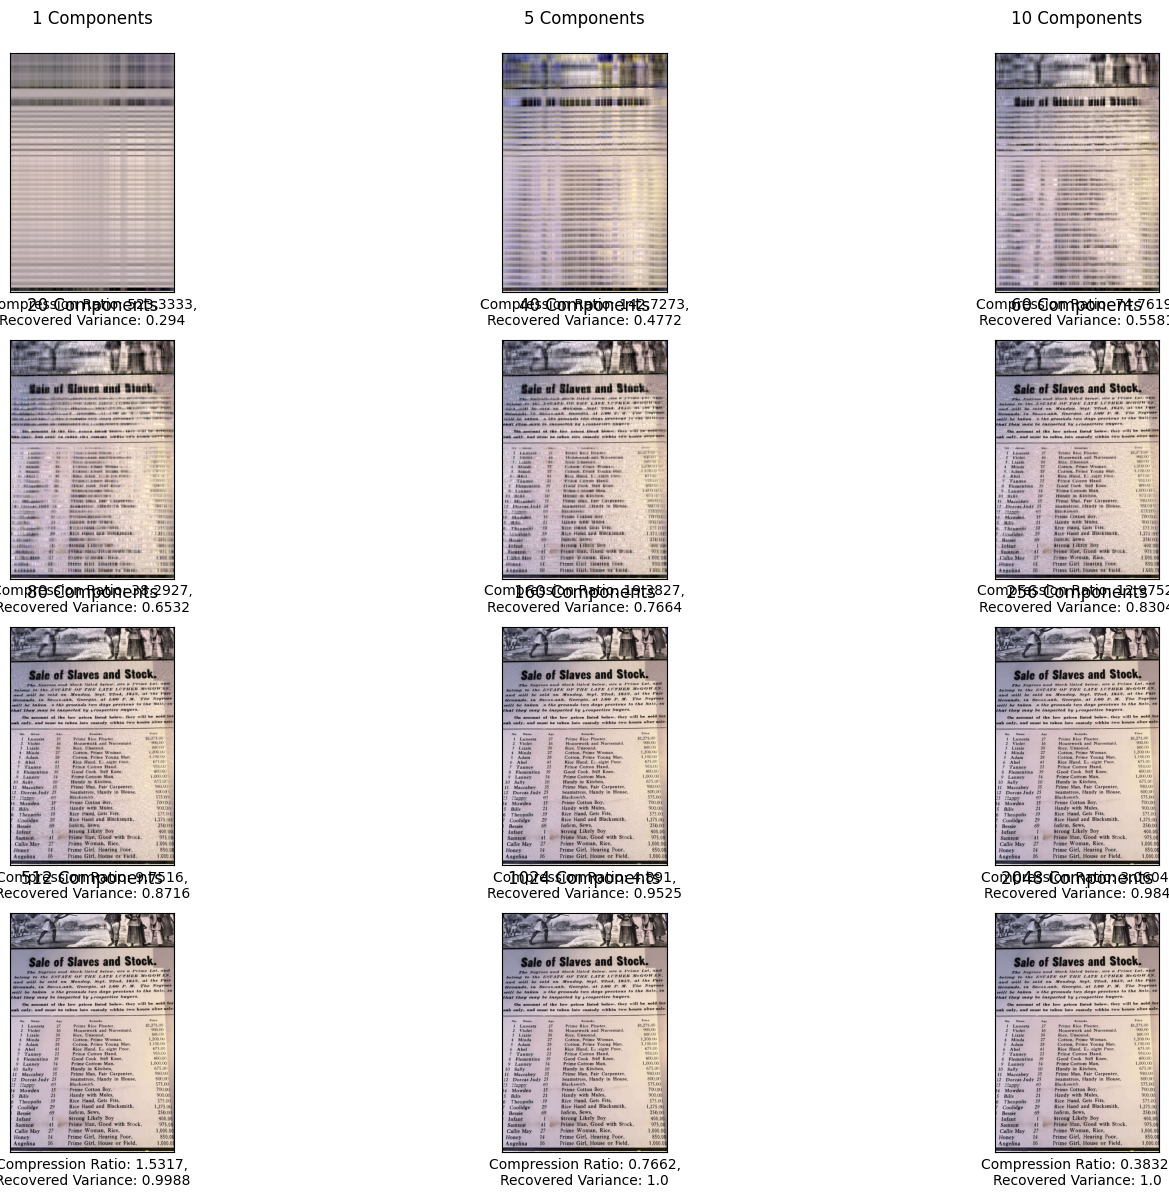

In [39]:
src2 = "../../MyDataset/Pinkrat/slaves.jpg"
img = cv2.cvtColor(cv2.imread("../../MyDataset/Pinkrat/slaves.jpg"), cv2.COLOR_BGR2RGB) ## Read the image

img = img.astype(np.float64) / 255 # Convert to float64 and normalize

img_mean = np.mean(img, axis=(0, 1)) ## Get the mean of the image
img -= img_mean

# U, S, V = svd(img) ## Perform SVD on the image
component_num = [1, 5, 10, 20, 40, 60, 80, 160, 256, 512, 1024, 2048] ## Number of components
fig = plt.figure(figsize=(18, 18)) ## Create a figure

# plot several images
i = 0
for k in component_num:
    img_rebuild = np.zeros_like(img)
    for j in range(3): # Apply SVD to each channel separately
        U, S, V = svd(img[:, :, j]) ## Perform SVD on the image
        img_rebuild[:, :, j] = rebuildsvd(U, S, V, k) ## Rebuild the image
    c = np.around(compression_ratio(img, k), 4) ## Calculate the compression ratio
    r = np.around(recovered_variance_proportion(S, k), 4) ## Calculate the recovered variance

    ax = fig.add_subplot(5, 3, i+1, xticks=[], yticks=[]) ## Add a subplot
    ax.imshow(np.clip(img_rebuild + img_mean, 0, 1)) ## Show the image
    ax.set_title(f"{k} Components\n") ## Set the title
    ax.set_xlabel(f"Compression Ratio: {c},\nRecovered Variance: {r}") ## Set the x-axis label
    i = i + 1